# Notebook to serve as example of how to use polaraveraging
### created by Mijin & Marina
################################################################

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import clmm.polaraveraging as pa
import clmm.galaxycluster as gc

### Read in the data (here cosmoDC2)

In [11]:
cosmo_object_type = "astropy"
try:
    import pyccl
except:
    cosmo_object_type = "astropy"
if cosmo_object_type == "astropy":
    from astropy.cosmology import FlatLambdaCDM
    cosmo = FlatLambdaCDM(70., Om0 = 0.3) # astropy cosmology setting, will be replaced by ccl
elif cosmo_object_type == "ccl":
    import pyccl as ccl
    cosmo = ccl.Cosmology(Omega_c=0.25, Omega_b = 0.05,h = 0.7,n_s = 0.97, sigma8 = 0.8, Omega_k = 0.)

## Load cluster object

In [28]:
#the cluster object contains properties of the lens: ra_l, dec_l, z_l and that of the sources : ra_s, dec_s, e1, e1 
cl = gc.load_cluster('9687686568.p')
print("cluster info , ID:", cl.unique_id, "ra:", cl.ra, "dec:", cl.dec, "z_l", cl.z)

cluster info , ID: 9687686568 ra: 62.668306457905786 dec: -39.809489570722384 z_l 0.3743791939334802


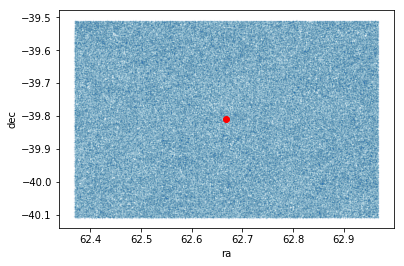

In [37]:
#plot cluster and galaxy positions
plt.scatter(cl.galcat['ra'],cl.galcat['dec'],s= 0.1, alpha=0.1)
plt.plot(cl.ra,cl.dec, 'ro')
plt.ylabel('dec')
plt.xlabel('ra');

## Compute and plot shear profiles

In [4]:
#calculate angular separation and tangential shear and cross shear for each source galaxy
theta, g_t , g_x = pa.compute_shear(cl, geometry = "flat")

In [5]:
#compute transversal and cross shear profiles in units defined by user, using defaults binning 
tab = pa.make_shear_profile(cl, "Mpc", bins=None, cosmo = cosmo, cosmo_object_type="astropy")

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9bc2340ba8>)

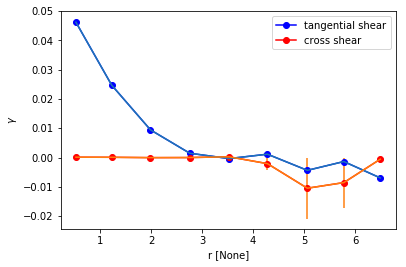

In [6]:
pa.plot_profiles(cl)

In [7]:
#define bins
new_bins = pa.make_bins(0.1, 3.7,20) 

#compute transversal and cross shear profiles in units defined by user, using binning defined by user
new_tab = pa.make_shear_profile(cl, "Mpc", bins=new_bins, cosmo = cosmo, cosmo_object_type="astropy")

#BE CAREFULL BECAUSE THIS OVERWRITE THE CLUSTER OBJECT (better implementation will be done latter)

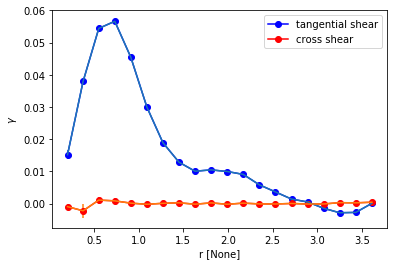

In [8]:
fig, ax = pa.plot_profiles(cl)

## You can also access the profiles quantities and play with them

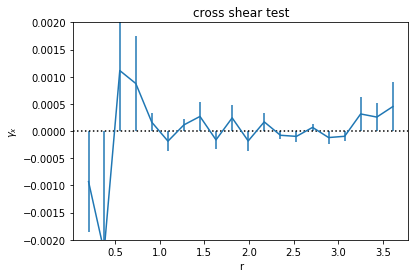

In [9]:
plt.title('cross shear test')
plt.errorbar(new_tab['radius'],new_tab['gx'],new_tab['gx_err'])
plt.title('cross shear test')
plt.ylim(-0.002,0.002)
plt.axhline(0, linestyle = 'dotted', color = 'black')
plt.xlabel("r")
plt.ylabel('$\\gamma_x$');